## DeepCycle
### This notebook outlines steps required to reproduce approach from DeepCycle manuscript. For data preparation, model training and cell encoding please refer to README.

In [276]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

import logging
logging.getLogger('matplotlib').setLevel(logging.ERROR)

# make user code available:
import sys
from pathlib import Path
module_path = str(Path('../src').absolute())
if module_path not in sys.path:
    sys.path.insert(0, module_path)

# curated_tracks - cell tracks syncronized on 1 division events
# double_division_tracks - cell tracks syncronized on 2 division events
from const import double_division_tracks, curated_tracks, DATA_ROOT

import pickle
import numpy as np
from numpy import savez_compressed, load
import pandas as pd
import cv2
import sompy
from scipy.interpolate import interp1d, NearestNDInterpolator
from scipy.stats import pearsonr

%matplotlib inline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.style.use('_classic_test')

from notebook_functions import umap_transform, plot_distributions, correlation_plot, correlation_plot_all,\
                timelapse_single_frame_sync, timelapse_double_frame_sync,\
                circular_tracking, normalize_intensities, project_onto_fluo_plane

log_const = 300

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Accuracy: 0.7276735363477904
[[0.76467981 0.04431642 0.11145579 0.07954797]
 [0.3943662  0.16784038 0.06220657 0.37558685]
 [0.07773217 0.00102617 0.84992304 0.07131862]
 [0.33061224 0.03673469 0.24489796 0.3877551 ]]


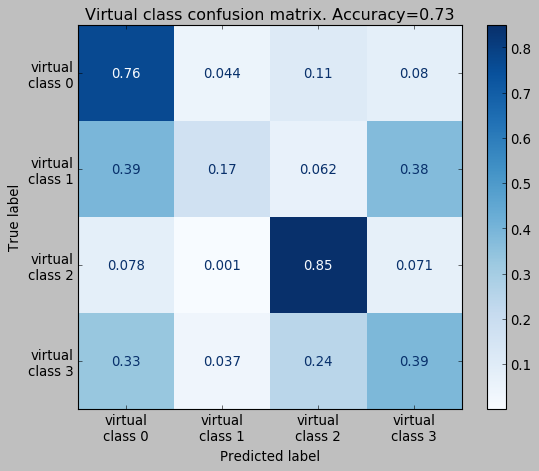

(9753, 4) (9753, 4) (9753, 2)


In [3]:
# load cell descriptors where 
# y - true class [1..4] one hot encoded, 
# descriptors - 4-component vectors obtained on validation set; validation set is double_division_tracks, 
# intensities - 2-component intensities of the cell

with open(DATA_ROOT / 'descriptors.r34.sz48.pkl', 'rb') as f:
    y, descriptors, intensities, df_index = pickle.load(f)
    
y_pred = np.argmax(descriptors, axis=1)
y_true = np.argmax(y, axis=1)
classes = sorted(np.unique(y_true))

acc = (y_pred == y_true).sum() / len(y_pred)
print('Accuracy:', acc)

confusion_mx = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None, normalize='true')
print(confusion_mx)

nl = '\n'
disp = ConfusionMatrixDisplay(confusion_mx, [f'virtual{nl}class {c}' for c in classes])
_ = disp.plot(cmap='Blues')
fig = plt.gcf()
_ = fig.set_size_inches(8, 6)
_ = disp.ax_.set_title(f'Virtual class confusion matrix. Accuracy={acc:.2f}')
# fig.savefig('conf_matrix_2channel.png', dpi=100)
plt.show()

descriptors = np.log(descriptors + 1e-7)
intensities = np.log(intensities + log_const)
print(y.shape, descriptors.shape, intensities.shape)

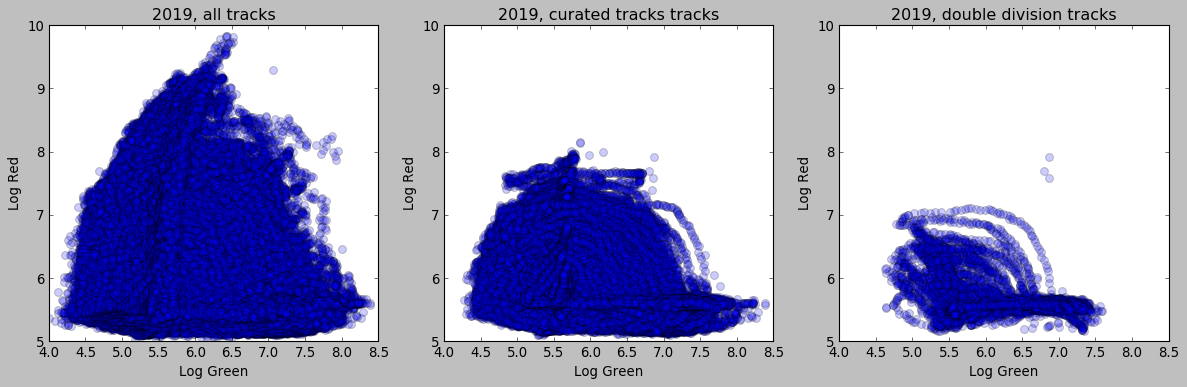

In [4]:
# load cell statistics and plot distributions for all, curated and double division tracks - across all frames.

cell_df = pd.read_csv(DATA_ROOT / 'statistics_mean_std.csv')
intensities_all = cell_df[['GFP_20', 'Cy3_20']].values
intensities_all = np.log(intensities_all + log_const)

intensities_curated_tracks = cell_df.loc[cell_df['TRACK_ID'].isin(curated_tracks), ['GFP_20', 'Cy3_20']].values
intensities_curated_tracks = np.log(intensities_curated_tracks + log_const)

intensities_double_division = cell_df.loc[cell_df['TRACK_ID'].isin(double_division_tracks), ['GFP_20', 'Cy3_20']].values
intensities_double_division = np.log(intensities_double_division + log_const)


plot_distributions((intensities_all, '2019, all tracks'),
                   (intensities_curated_tracks, '2019, curated tracks tracks'),
                   (intensities_double_division, '2019, double division tracks'))

## Timelapse

In [5]:
# 'intensities.csv' contains ~1000 tracks synchronized on 1 division event in 'time' column

df = pd.read_csv(DATA_ROOT / 'intensities.csv', header=[0, 1, 2])

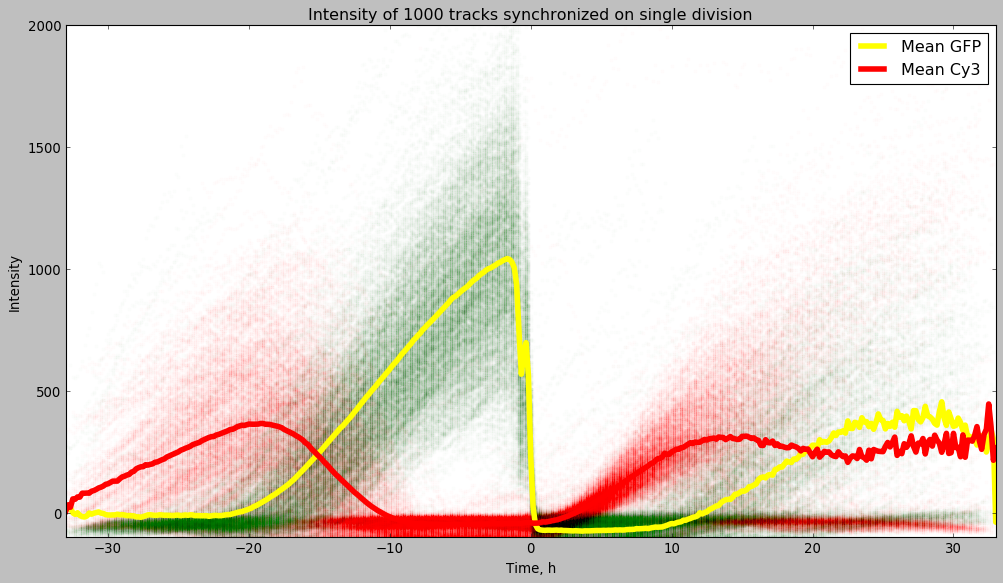

In [6]:
# plot average intensities of single division tracks

average_single_division_track = timelapse_single_frame_sync(df, curated_tracks)

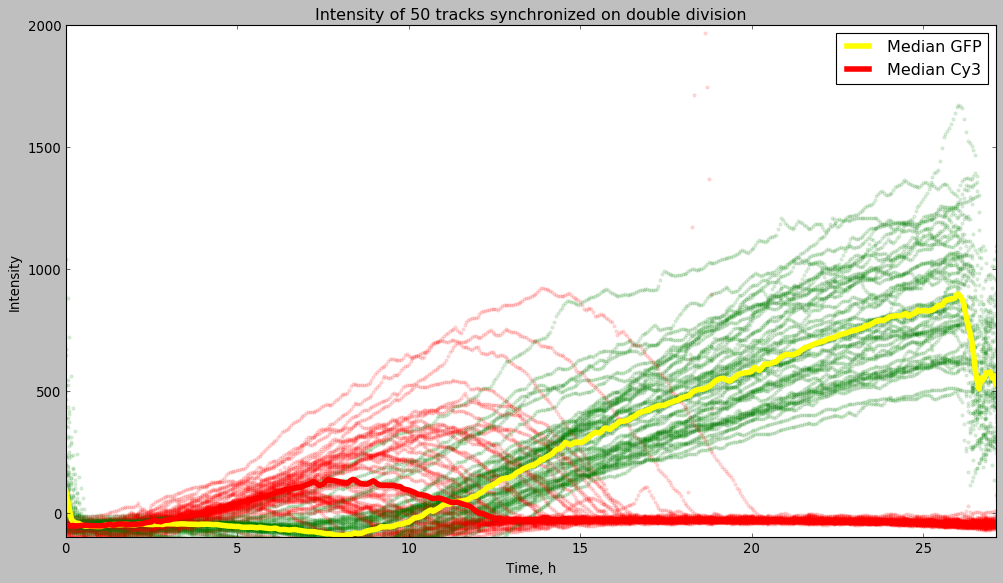

In [7]:
# plot average intensities of double division tracks

average_double_division_track, ax, _ = timelapse_double_frame_sync(df, double_division_tracks, nnods=500)

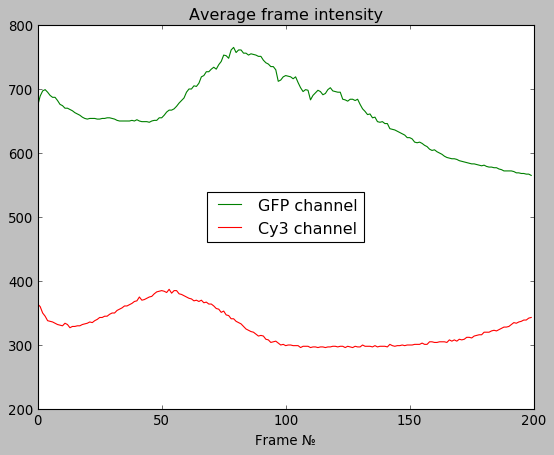

In [8]:
# plot average frame intensities for GFP and Cy3 channels

g_mean_tl, r_mean_tl = df[['gfp_frame_average', 'cy3_frame_average']].T.values

plt.plot(g_mean_tl, 'g', label='GFP channel')
plt.plot(r_mean_tl, 'r', label='Cy3 channel')
plt.legend(loc = 'center')
plt.title('Average frame intensity')
plt.xlabel('Frame №')
plt.show()

## U-Map embedding

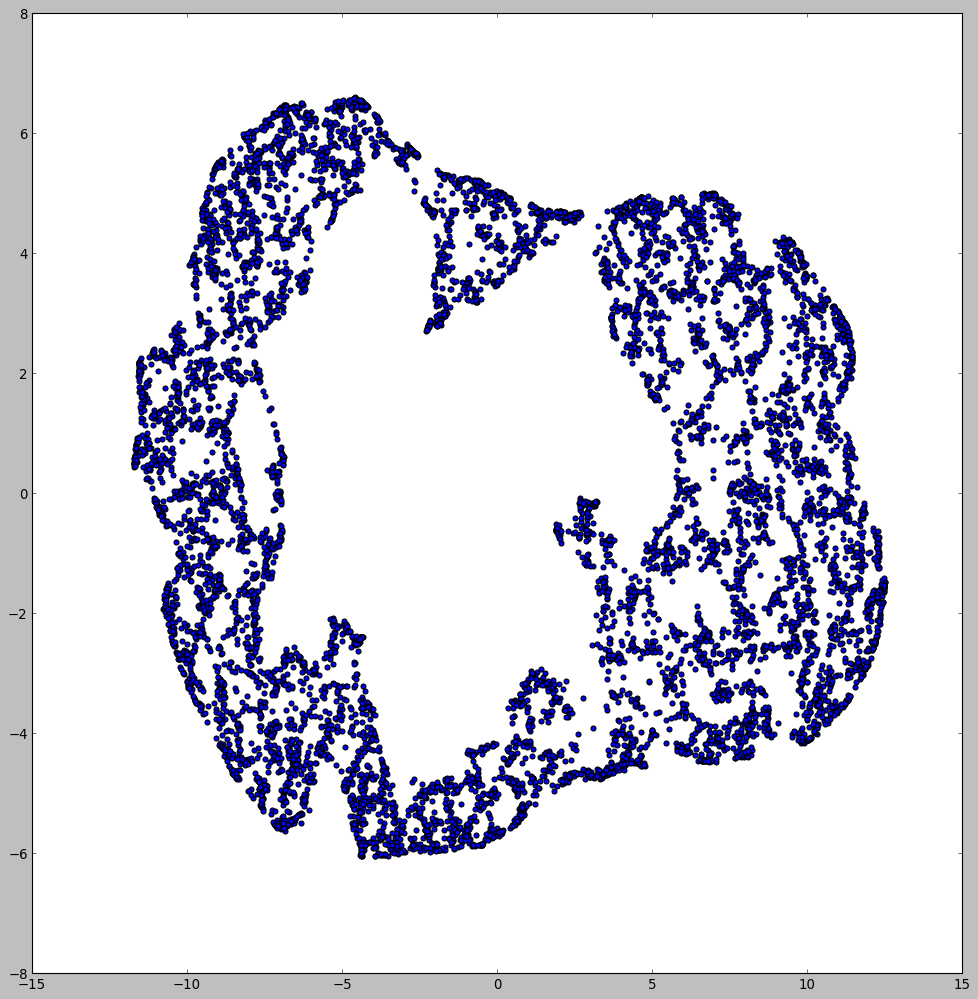

In [9]:
embeddings_preds, fit = umap_transform(descriptors, n_neighbors=300, min_dist=0.05, n_components=2, metric='correlation')

fig = plt.figure(figsize=(15, 15))
plt.scatter(embeddings_preds[:, 0], embeddings_preds[:, 1])

## Finding average track with SOM clustering

In [10]:
mapsize = 30
som = sompy.SOMFactory.build(embeddings_preds, mapsize, mask=None, mapshape='cylinder', lattice='rect',
                             normalization='None', initialization='spherical', neighborhood='gaussian',
                             training='batch', name='sompy', track_history=True)
som.train(n_job=1, verbose=None)

som_matrix = som.codebook.matrix  # SOM track coordinates, shape = mapsize x 2
som_bmu = som._bmu[0].astype(int) # assigned SOM class,  shape = len(embeddings_preds)

input was considered as the numbers of nodes
map size is [1,30]


In [11]:
som_translation_tbl = np.roll(sorted(np.unique(som_bmu))[::-1], -8)  # rearranged class progression 0...29 -> 21...0, 29...22

som_matrix = som_matrix[som_translation_tbl]
som_bmu = som_translation_tbl[som_bmu]

In [12]:
fun = np.median
som_track = []
for cluster in np.sort(np.unique(som_bmu)):
    som_track.append(fun(intensities[som_bmu == cluster], 0))
som_track = np.array(som_track)  # average intensities of SOM clusters, shape = mapsize x 2

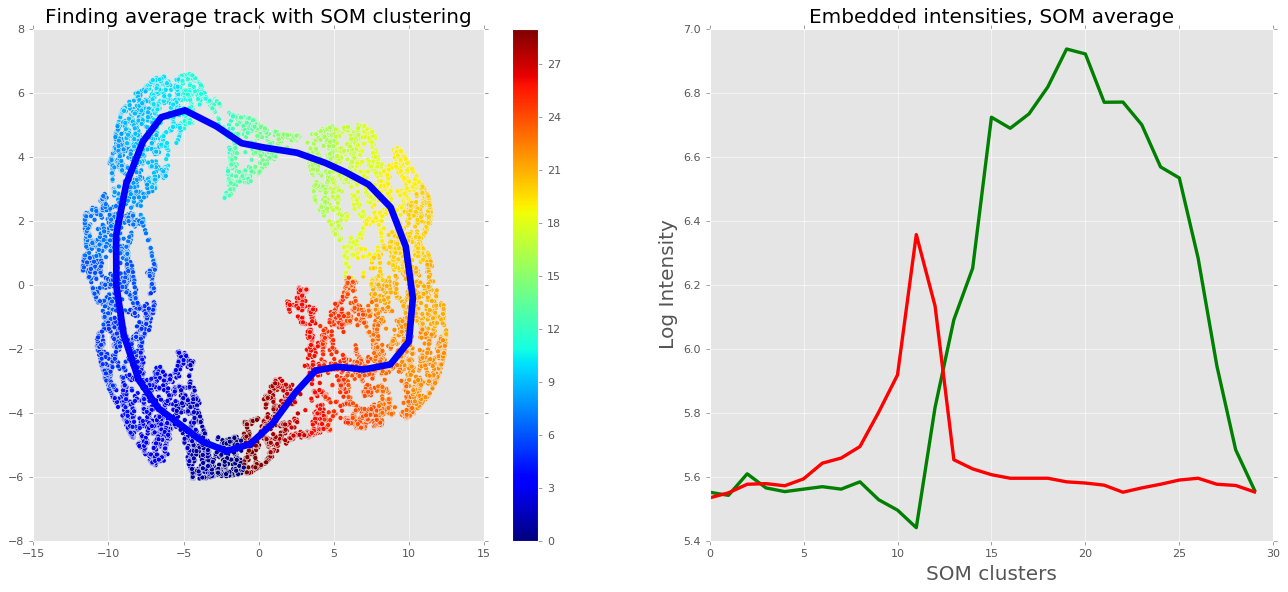

In [28]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

color = 'blue'
im = ax1.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=som_bmu)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax1.set_title('Finding average track with SOM clustering', fontsize=18)
fig.colorbar(im, ax=ax1)

ax2.plot(som_track[:, 0], c='green', linewidth=3)
ax2.plot(som_track[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('SOM clusters', fontsize=18)
ax2.set_title('Embedded intensities, SOM average', fontsize=18)


plt.show()

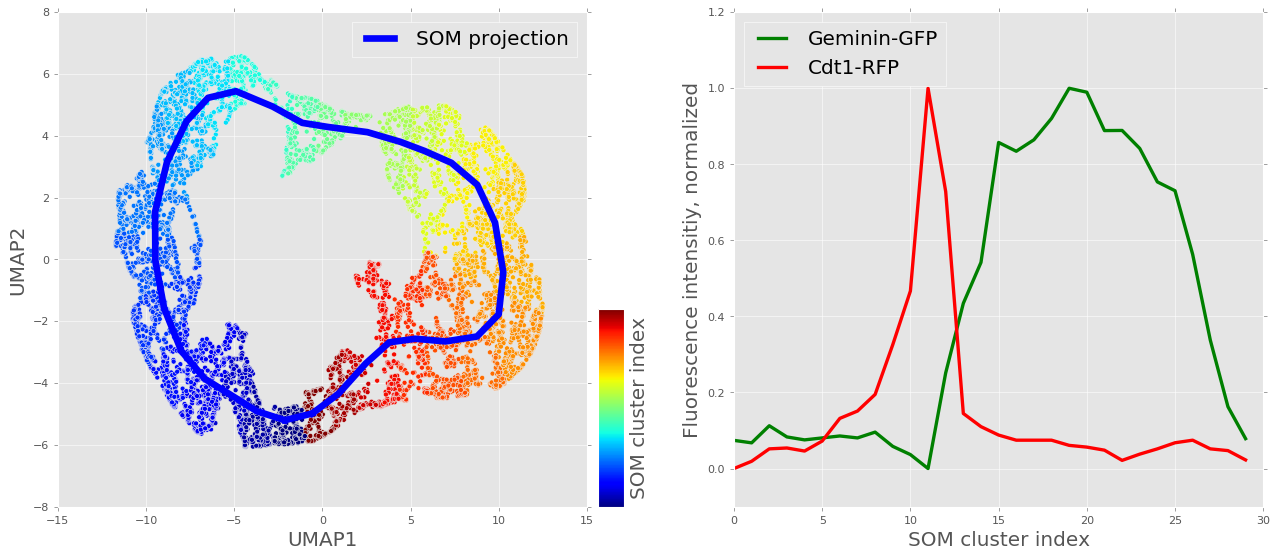

In [29]:
plt.style.use('_classic_test')
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(18, 9), gridspec_kw={'width_ratios': [1, 1]})

color = 'blue'
im = ax1.scatter(embeddings_preds[:,0], embeddings_preds[:,1], c=som_bmu)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax1.set_ylabel('UMAP2', fontsize=18)
ax1.set_xlabel('UMAP1', fontsize=18)
ax1.legend(['SOM projection'], fontsize=18, loc='upper right')
axins = inset_axes(ax1,
                   width="5%",  # width = 5% of parent_bbox width
                   height="40%",  # height : 30%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0,
                   )
cbar = fig.colorbar(im, ax=ax1, cax=axins, ticks=[])
cbar.set_label('SOM cluster index', fontsize=18)


som_track_normalized = som_track - som_track.min(0)
som_track_normalized /= som_track_normalized.max(0)
ax2.plot(som_track_normalized[:, 0], c='green', linewidth=3)
ax2.plot(som_track_normalized[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Fluorescence intensitiy, normalized', fontsize=18)
ax2.set_xlabel('SOM cluster index', fontsize=18)
ax2.legend(['Geminin-GFP', 'Cdt1-RFP'], fontsize=18, loc='upper left')
ax2.set_ylim((-0.1, 1.2))

plt.tight_layout(pad=8)
plt.savefig('Fig3norm.png')
plt.show()

### Project SOM averaged trajectory back onto fluo plane

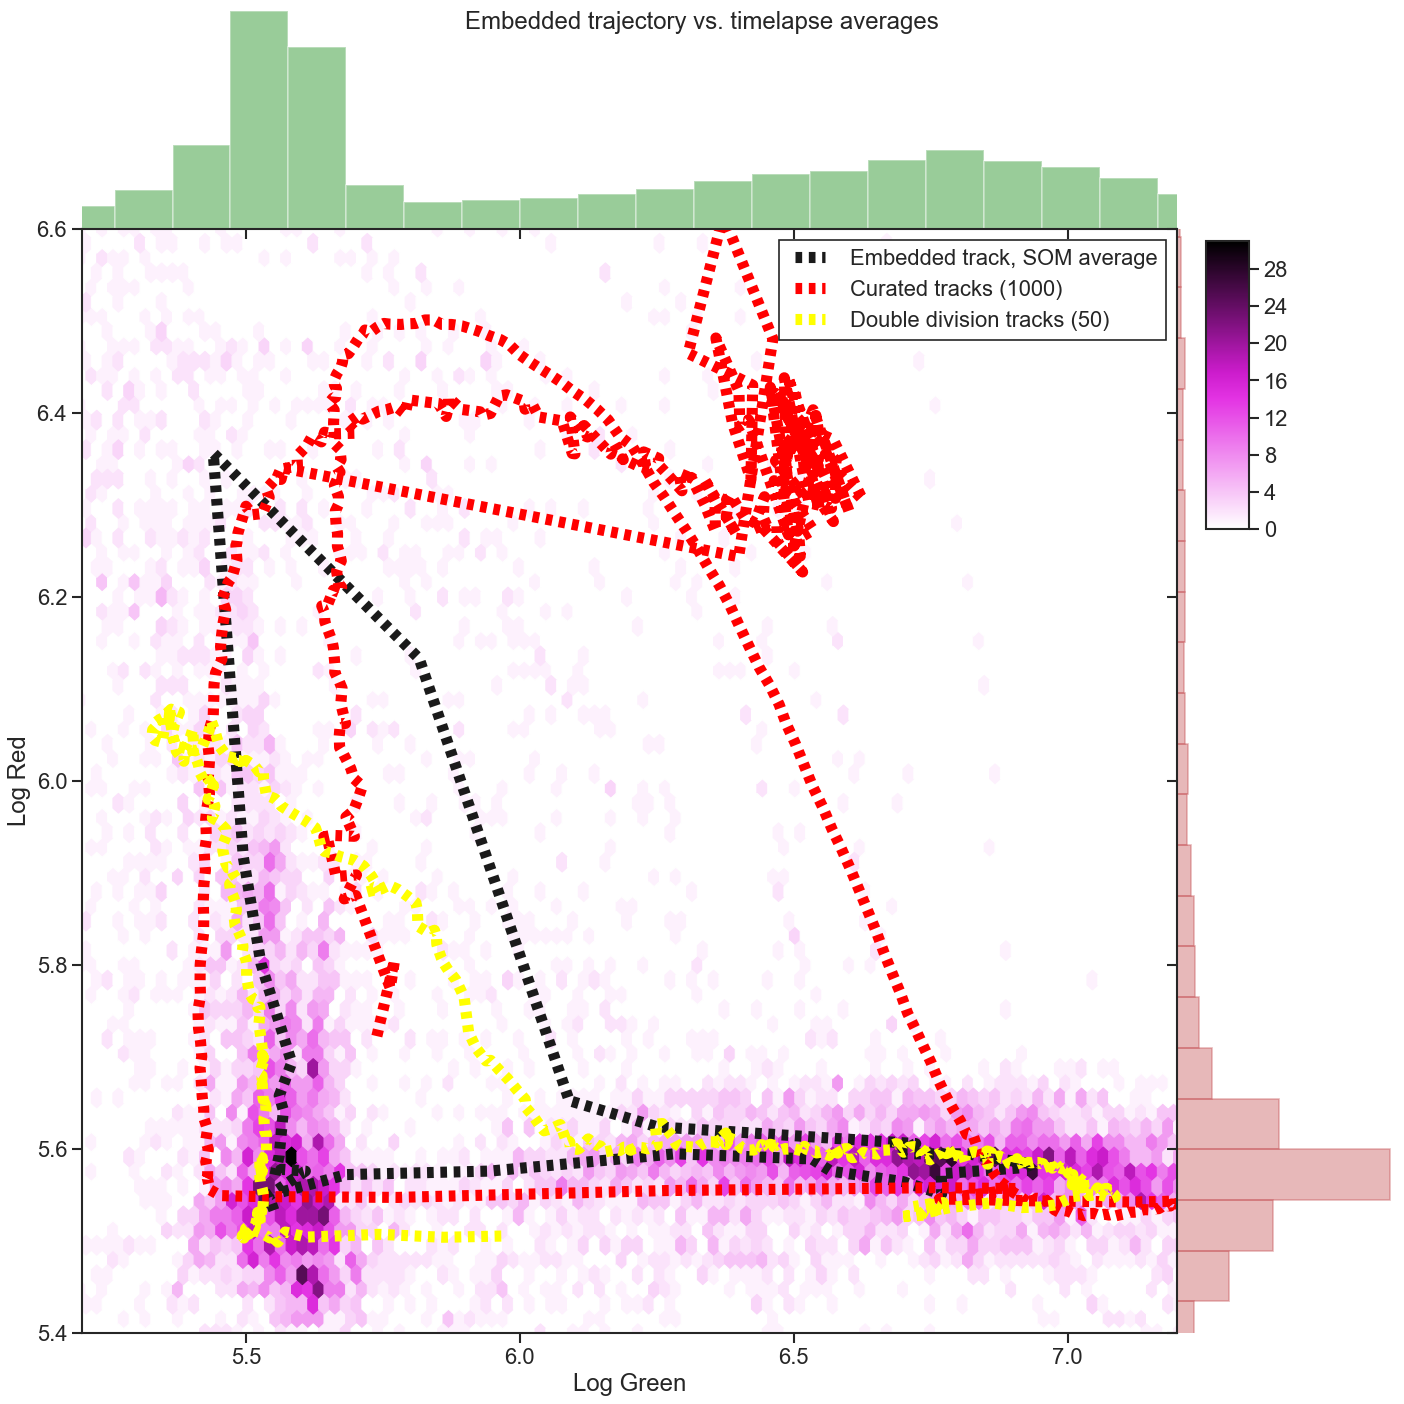

In [30]:
project_onto_fluo_plane(intensities, 
                        (som_track, 'k', 'Embedded track, SOM average'), 
                        (np.log(average_single_division_track + log_const), 'red', 'Curated tracks (1000)'), 
                        (np.log(average_double_division_track + log_const), 'yellow', 'Double division tracks (50)'), 
                        log_const=300)

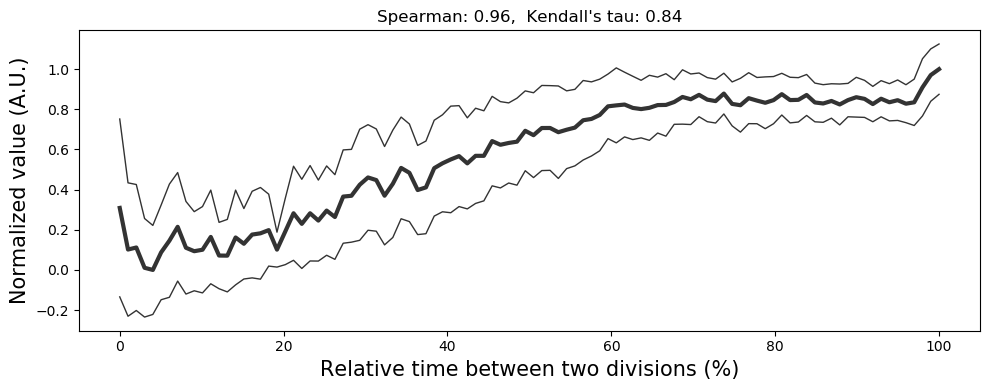

In [278]:
correlation_plot(cell_df, df_index, som_bmu, gfp_key='GFP_20', cy3_key='Cy3_20')

# Cell cycle reconstruction using unseen data

In [53]:
with open(DATA_ROOT / 'descriptors_all.r34.sz48.pkl', 'rb') as f:
    y_all, descriptors_all, intensities_all, df_index_all = pickle.load(f)
descriptors_all = np.log(descriptors_all + 1e-7)
intensities_all = np.log(intensities_all + log_const)
print(y_all.shape, descriptors_all.shape, intensities_all.shape)

(2684453, 4) (2684453, 4) (2684453, 2)


In [54]:
# load all dataset embeddings (obtained with all_cells_prediction.py)
embeddings_preds_all = []
for i in range(20):
    data = load(DATA_ROOT / f'embeddings_preds_all_batch{i}.npz')
    embeddings_preds_all.append(data['arr_0'])
embeddings_preds_all = np.vstack(embeddings_preds_all)

In [260]:
# filter unseen tracks
filter = ~cell_df.loc[df_index_all.flatten(), 'TRACK_ID'].isin(list(double_division_tracks) + curated_tracks)
y_all = y_all[filter]
descriptors_all = descriptors_all[filter]
intensities_all = intensities_all[filter]
df_index_all = df_index_all[filter]
embeddings_preds_all = embeddings_preds_all[filter]
print(y_all.shape, descriptors_all.shape, intensities_all.shape, embeddings_preds_all.shape)

(2366415, 4) (2366415, 4) (2366415, 2) (2366415, 2)


In [261]:
som_bmu_all = som_translation_tbl[som.project_data(embeddings_preds_all)]

In [262]:
fun = np.median
som_track_all = []
for cluster in np.sort(np.unique(som_bmu_all)):
    som_track_all.append(fun(intensities_all[::1][som_bmu_all == cluster], 0))
som_track_all = np.array(som_track_all)

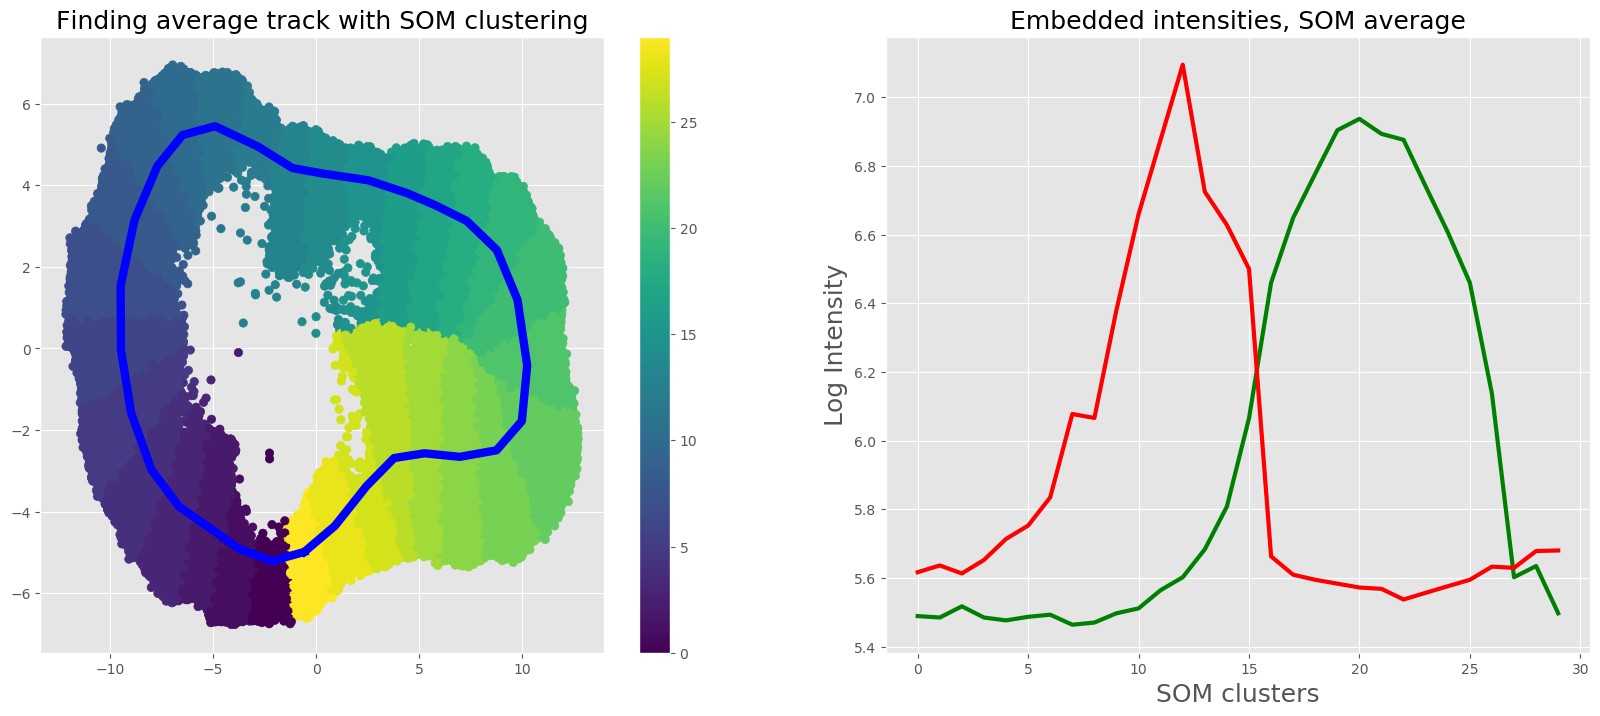

In [263]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 8))

color = 'blue'
im = ax1.scatter(embeddings_preds_all[:,0], embeddings_preds_all[:,1], c=som_bmu_all)
ax1.plot(som_matrix[:,0], som_matrix[:,1], '-', linewidth=6, c=color)
ax1.plot([som_matrix[-1, 0], som_matrix[0, 0]], [som_matrix[-1, 1], som_matrix[0, 1]], '-', linewidth=6, c=color)
ax1.set_title('Finding average track with SOM clustering', fontsize=18)
fig.colorbar(im, ax=ax1)

ax2.plot(som_track_all[:, 0], c='green', linewidth=3)
ax2.plot(som_track_all[:, 1], c='red', linewidth=3)
ax2.set_ylabel('Log Intensity', fontsize=18)
ax2.set_xlabel('SOM clusters', fontsize=18)
ax2.set_title('Embedded intensities, SOM average', fontsize=18)

plt.show()

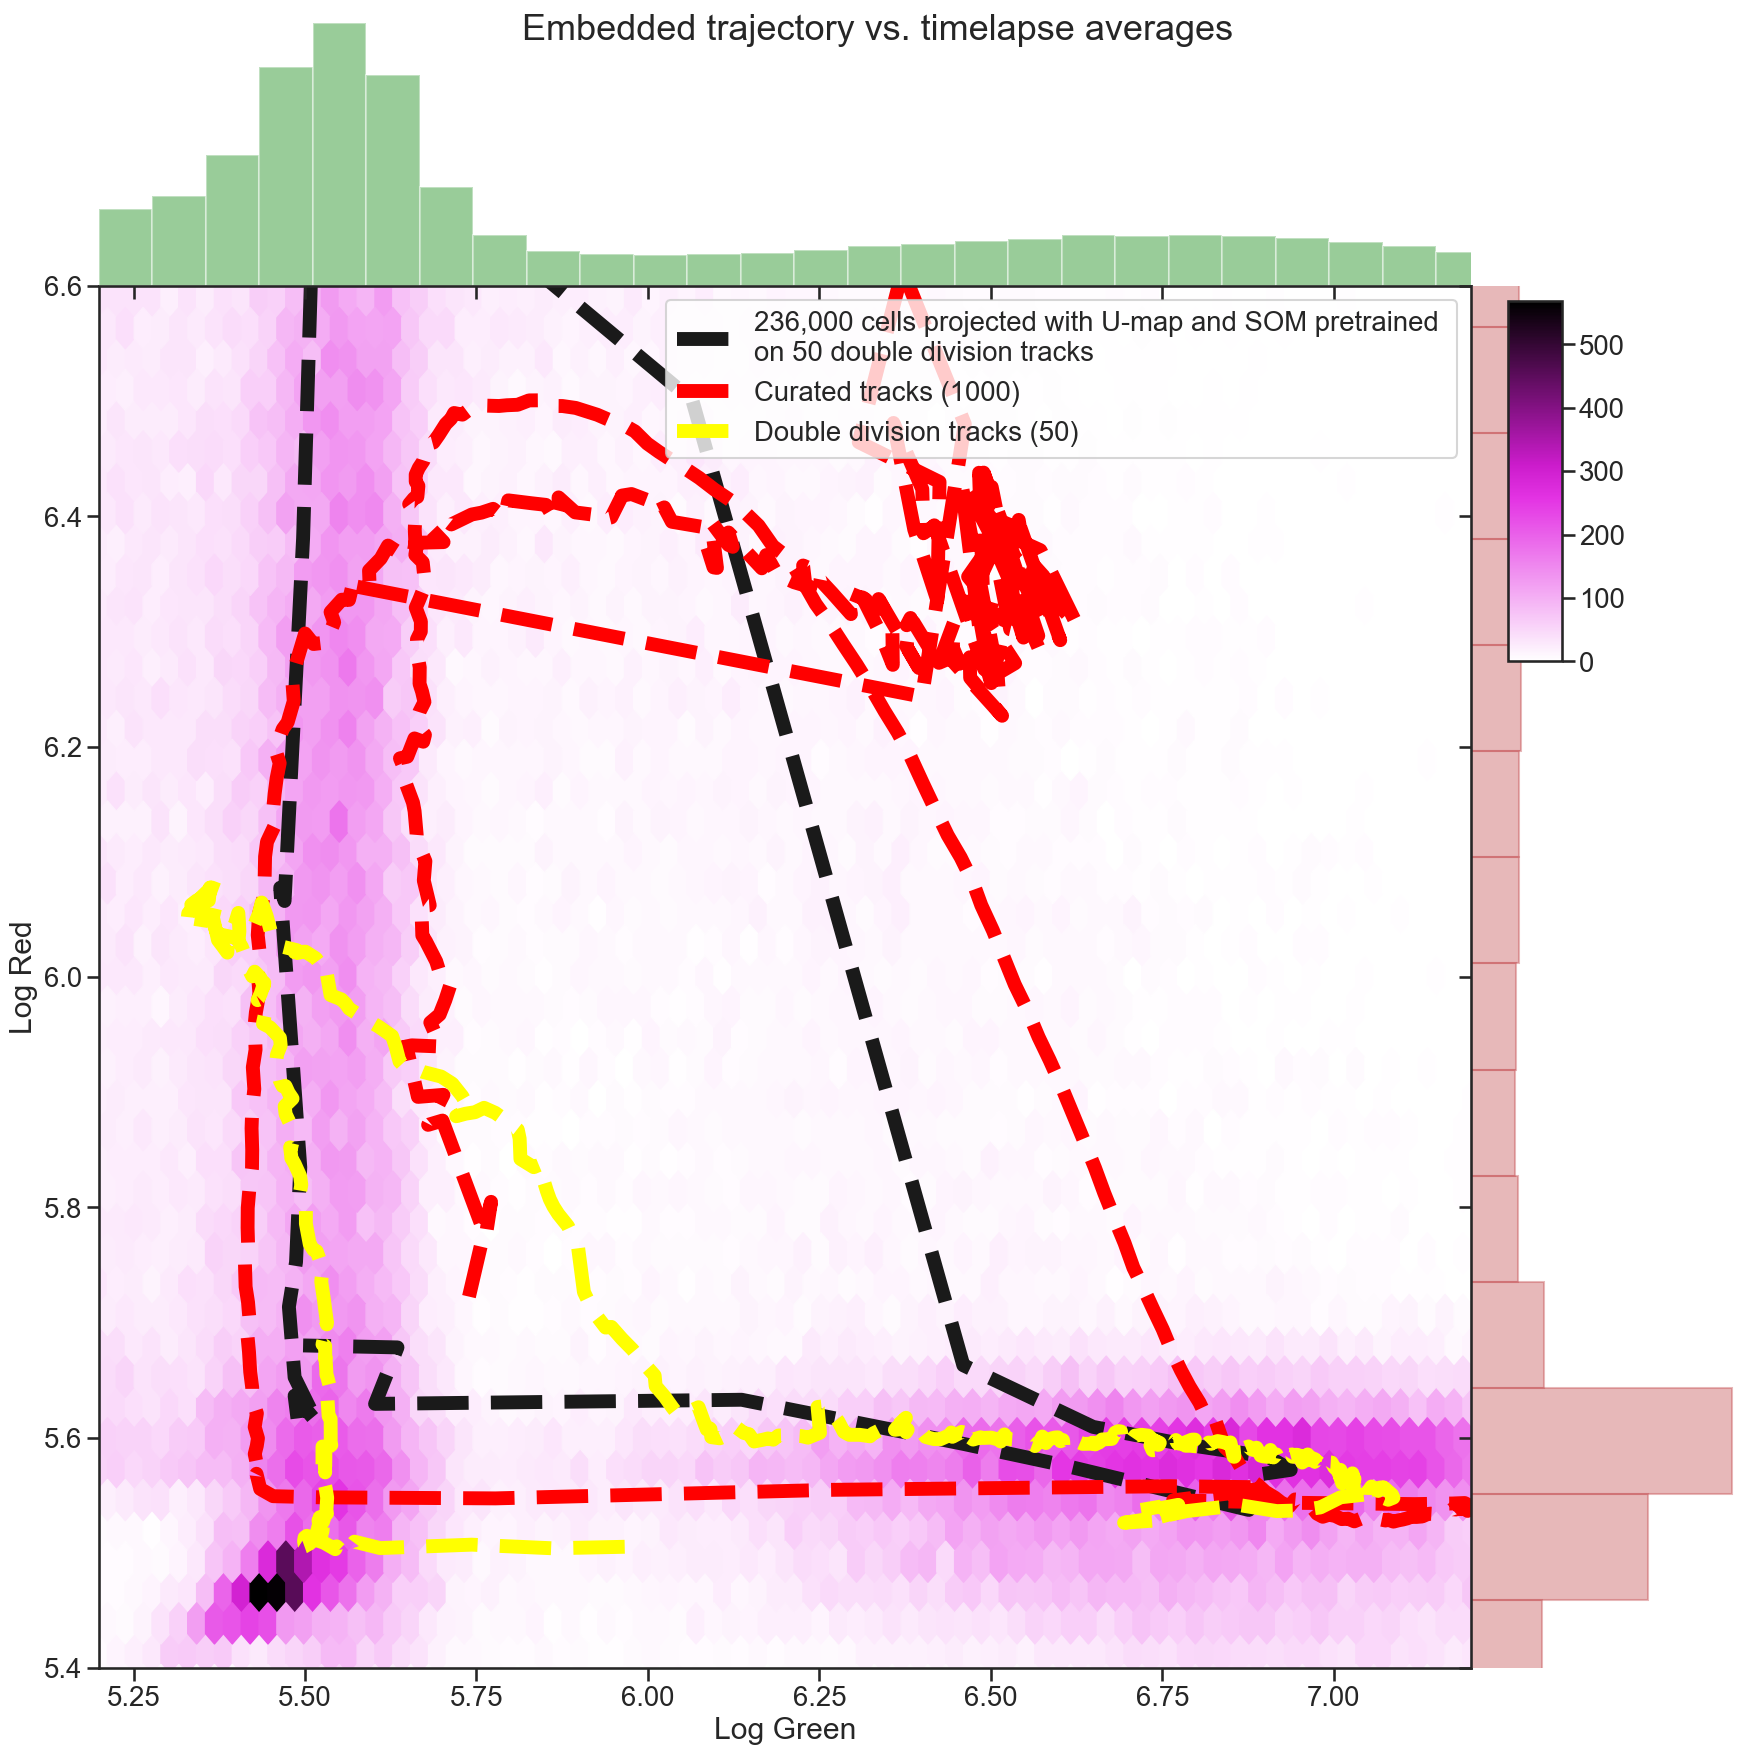

In [279]:
project_onto_fluo_plane(intensities_all[::10], 
                        (som_track_all, 'k', '236,000 cells projected with U-map and SOM pretrained \non 50 double division tracks'), 
                        (np.log(average_single_division_track + log_const), 'red', 'Curated tracks (1000)'), 
                        (np.log(average_double_division_track + log_const), 'yellow', 'Double division tracks (50)'), 
                        log_const=300)

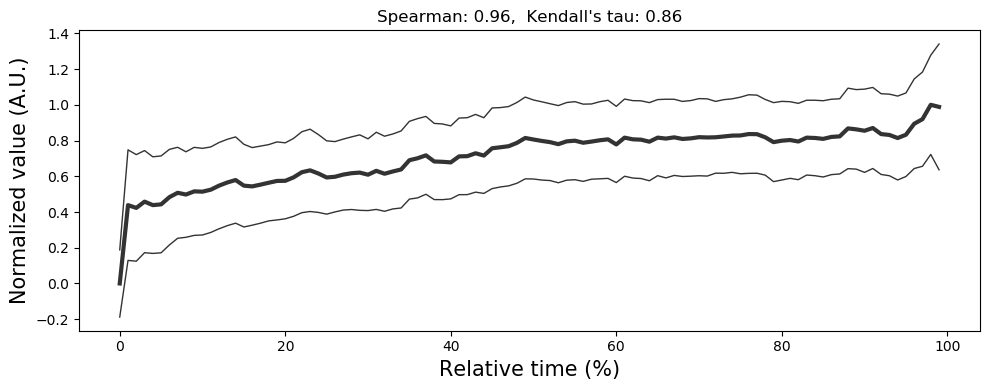

In [277]:
correlation_plot_all(cell_df, df_index_all, som_bmu_all)